In [1]:
from astropy.nddata import NDDataArray as nda, StdDevUncertainty as sdu
from astropy.table import Table, column
import astropy.units as u
import numpy as np
import os

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

import sys
sys.path.append('../astro_codes/')

In [4]:

import imp
import halo_modified
imp.reload(halo_modified)

### Milky Way for reference #######

m_b_mw = [4e9] * u.Msun
delta_m_b_mw = [0] * u.Msun

m_d_mw = [5.3e10] * u.Msun
delta_m_d_mw = [0.5e10] * u.Msun

a_b_mw = [0.6] * u.kpc
delta_a_b_mw = [0] * u.kpc

R_d_mw = [2.15] * u.kpc
delta_R_d_mw = [0.14] * u.kpc

m_hi_mw = None
delta_m_hi_mw = None

mw_halo = halo_modified.TotalHalo(m_b_mw,delta_m_b_mw,m_d_mw,delta_m_d_mw,
                                  a_b_mw,delta_a_b_mw,R_d_mw,delta_R_d_mw,
                                  m_hi_mw,delta_m_hi_mw,
                                  None,None,None,None,1,0)

m_h = mw_halo.halo_mass()[0].data * u.Msun
m_h_hernquist = mw_halo.halo_mass_hernquist()[0].data * u.Msun
rho0_burkert = mw_halo.burkert_rho0()[0].data * (u.Msun/u.kpc**3)
R_h = mw_halo.halo_scale_length()[0].data * u.kpc


#### First task: plot up a couple of haloes for a comparison plot

Whether this makes it into the paper or not is another issue, but could be a nice issue to explain points in the paper.

I will use the 'typical' example of the Milky Way.

In [5]:
def hernquist_halo(M,a,r):
    return (M/(2*math.pi)) * (a/r) * (1/(r+a)**3)

def burkert_halo(rho0,a,r):
    return rho0 * a**3 / ((r+a)*(r**2+a**2))

def nfw_halo(rho0,r_s,r):
    rho = rho0 /((r/r_s) * (1+r/r_s)**2)
    return rho
    

def alpha_halo(alpha):
    if alpha < 0:
        return (1+alpha)*rho_b
    elif 0 <= alpha <= 1:
        return alpha*rho_h + (1-alpha)*rho_b
    else:
        return (1+alpha)*rho_h

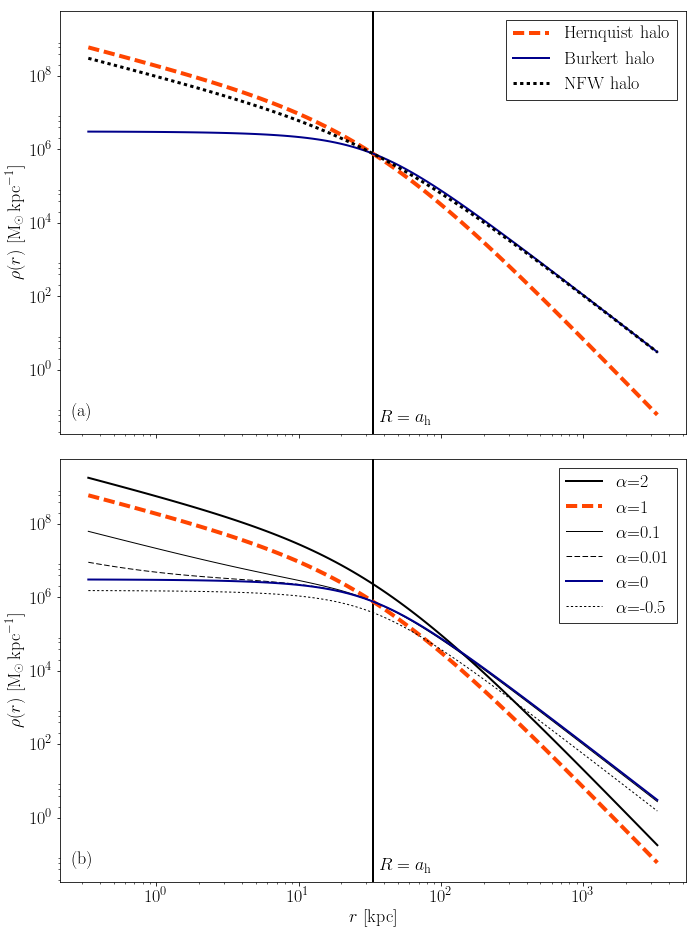

In [10]:
fig, axarr = plt.subplots(2,1,figsize=(10,13.3),sharex=True,sharey=True)

r = np.logspace(-2,2,100) * R_h.value
rho_h = hernquist_halo(m_h_hernquist.value,R_h.value,r)
rho_b = burkert_halo(rho0_burkert.value,R_h.value,r)
rho_n = nfw_halo(rho0_burkert.value,R_h.value,r)

ax = axarr[0]
plt.sca(ax)

_ = ax.plot(r,rho_h,color='orangered',lw=4,linestyle='dashed',
            label='Hernquist halo')
_ = ax.plot(r,rho_b,color='darkblue',lw=2,
            label='Burkert halo')
_ = ax.plot(r,rho_n,color='k',lw=3,linestyle='dotted',
            label='NFW halo')

##########################

ax = axarr[1]
plt.sca(ax)

alphas = (2,1,0.1,0.01,0,-0.5)
styles = ('solid','dashed','solid','dashed','solid','dotted')
colors = ('k','orangered','k','k','darkblue','k')
linewidths = (2,4,1,1,2,1)

for a, style, color, lw in zip(alphas,styles,colors,linewidths):
    rho = alpha_halo(a)
    _ = ax.plot(r,rho,color=color,linestyle=style,lw=lw,
                label=r'$\alpha$={}'.format(a))

###########################
for ax in axarr:
    plt.sca(ax)
    _ = plt.axvline(R_h.value,lw=2,color='k',zorder=-1)
    _ = ax.set_xscale('log')
    _ = ax.set_yscale('log')
    _ = ax.legend(fancybox=False,edgecolor='k')
    _ = ax.set_ylabel(r'$\rho (r)$ [$\mathrm{M_\odot \, kpc^{-1}}$]')
    _ = ax.text(0.51,0.01,'$R=a_\mathrm{h}$',
            transform=ax.transAxes,ha='left',va='bottom')

_ = axarr[0].text(0.02,0.03,'(a)',transform=axarr[0].transAxes,
                  ha='left',va='bottom')   
_ = axarr[1].text(0.02,0.03,'(b)',transform=axarr[1].transAxes,
                  ha='left',va='bottom')  

_ = axarr[1].set_xlabel('$r$ [kpc]')
fig.tight_layout()
fig.savefig('figures/halo_shapes.pdf')

#### Now, for the science part -- we should be able to calculate the required flattening to produce our spiral arm numbers.

In [11]:
# load the required data
masks = Table.read('fits/masks.fits')
morph_data = Table.read('fits/morph_data.fits')
structure_data = Table.read('fits/structure_data.fits')
halo_data = Table.read('fits/sdss_halo_table_matched.fits')
halo_w_gas = Table.read('fits/sdss_w_gas_table_matched.fits')

In [12]:
def calculate_alpha(m,m_b,m_d,m_hernquist,m_burkert):
    alpha = (m-m_b-m_d-m_burkert)/(m_hernquist-m_burkert)
    low_alpha = alpha < 0
    high_alpha = alpha > 1
    alpha[low_alpha] = ((m-m_b-m_d)/m_burkert - 1)[low_alpha]
    alpha[high_alpha] = ((m-m_b-m_d)/m_hernquist)[high_alpha]
    return alpha

# Gasless
m_observed = morph_data['m_avg']
m_disc = halo_data['m_disc']
m_bulge = halo_data['m_bulge']
m_burkert = halo_data['m_burkert']
m_hernquist = halo_data['m_hernquist']
M_b = halo_data['M_bulge_2.2']
M_d = halo_data['M_disc_2.2']
M_h_hernquist = halo_data['M_hernquist_2.2']
M_h_burkert = halo_data['M_burkert_2.2']

alphas = calculate_alpha(m_observed,m_bulge,m_disc,m_hernquist,m_burkert)

# Gassed
m_observed = morph_data['m_avg']
m_disc_hi = halo_data['m_disc']
m_bulge_hi = halo_data['m_bulge']
m_burkert_hi = halo_w_gas['m_burkert']
m_hernquist_hi = halo_w_gas['m_hernquist']
M_b_hi = halo_w_gas['M_bulge_2.2']
M_d_hi = halo_w_gas['M_disc_2.2']
M_h_hernquist_hi = halo_w_gas['M_hernquist_2.2']
M_h_burkert_hi = halo_w_gas['M_burkert_2.2']

alphas_hi = calculate_alpha(m_observed,m_bulge_hi,m_disc_hi,
                            m_hernquist_hi,m_burkert_hi)

in_sdss = masks['z<0.085 (unbarred spiral)']
in_sdss_hi = masks['z<0.085 (+HI unbarred spiral)']


#### Define two parameters: $\alpha$ for the halo contraction, and $\epsilon$ for the associated mass enclosed fraction (Dutton+16)

In [13]:
# Now: how does alpha correlate with M/M_DMO [0.01R200]

def mass_enclosed_hernquist(r,M200,a_h,r200):
    return M200 * (r**2 / (r+a_h)**2)

def mass_enclosed_burkert(r,M200,a_h,rho0,r200):
    
    a = 2 * math.pi * rho0 * a_h**3
    b = (np.log((r+a_h)/a_h)
       + 0.5 * np.log((r**2 + a_h**2)/a_h**2)
       - np.arctan(r/a_h))
    return a * b

def alpha_to_epsilon(table,alpha):
    M200_hernquist = table['M_h_hernquist']
    M200_burkert = table['M_halo']
    R200 = table['R200']
    a_h = table['R_halo']
    rho0 = table['rho0']
    # mass of each halo w/i 0.01 R200:
    r = 0.01 * R200
    M_hernquist = mass_enclosed_hernquist(r,M200_hernquist,a_h,R200)
    M_burkert = mass_enclosed_burkert(r,M200_burkert,a_h,rho0,R200)
    # calculate mass enclosed:
    low_alpha = alpha < 0
    mid_alpha = (0 <= alpha) & (alpha <= 1)
    high_alpha = alpha > 1
    mass_enclosed = np.zeros(len(alpha))
    mass_enclosed[low_alpha] = ((1+alpha)*M_burkert)[low_alpha]
    mass_enclosed[mid_alpha] = ((1-alpha)*M_burkert 
                              + alpha*M_hernquist)[mid_alpha]
    mass_enclosed[high_alpha] = (alpha*M_hernquist)[high_alpha]
    
    return mass_enclosed / M_hernquist

def epsilon_to_alpha(table,epsilon):
    M200_hernquist = table['M_h_hernquist']
    M200_burkert = table['M_halo']
    R200 = table['R200']
    a_h = table['R_halo']
    rho0 = table['rho0']
    # mass of each halo w/i 0.01 R200:
    r = 0.01 * R200
    M_hernquist = mass_enclosed_hernquist(r,M200_hernquist,a_h,R200)
    M_burkert = mass_enclosed_burkert(r,M200_burkert,a_h,rho0,R200)
    # calculate mass enclosed:
    alpha = (epsilon*M_hernquist - M_burkert) / (M_hernquist-M_burkert)
    low_alpha = alpha < 0
    high_alpha = alpha > 1
    alpha[high_alpha] = epsilon[high_alpha]
    alpha[low_alpha] = (epsilon*(M_hernquist/M_burkert) - 1)[low_alpha]
    return alpha
    
epsilon = alpha_to_epsilon(halo_data,alphas)
epsilon_hi = alpha_to_epsilon(halo_w_gas,alphas_hi)

log_epsilon = np.log10(epsilon)
log_epsilon[np.isfinite(log_epsilon) == False] = -999

log_epsilon_hi = np.log10(epsilon_hi)
log_epsilon_hi[np.isfinite(log_epsilon_hi) == False] = -999

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:57: RuntimeWarning: invalid value encountered in log10
/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:60: RuntimeWarning: invalid value encountered in log10


3157/7611 (41.479437656024174%) have reasonable epsilons
2489/5696 (43.69733146067416%) have reasonable epsilons (+HI)


/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


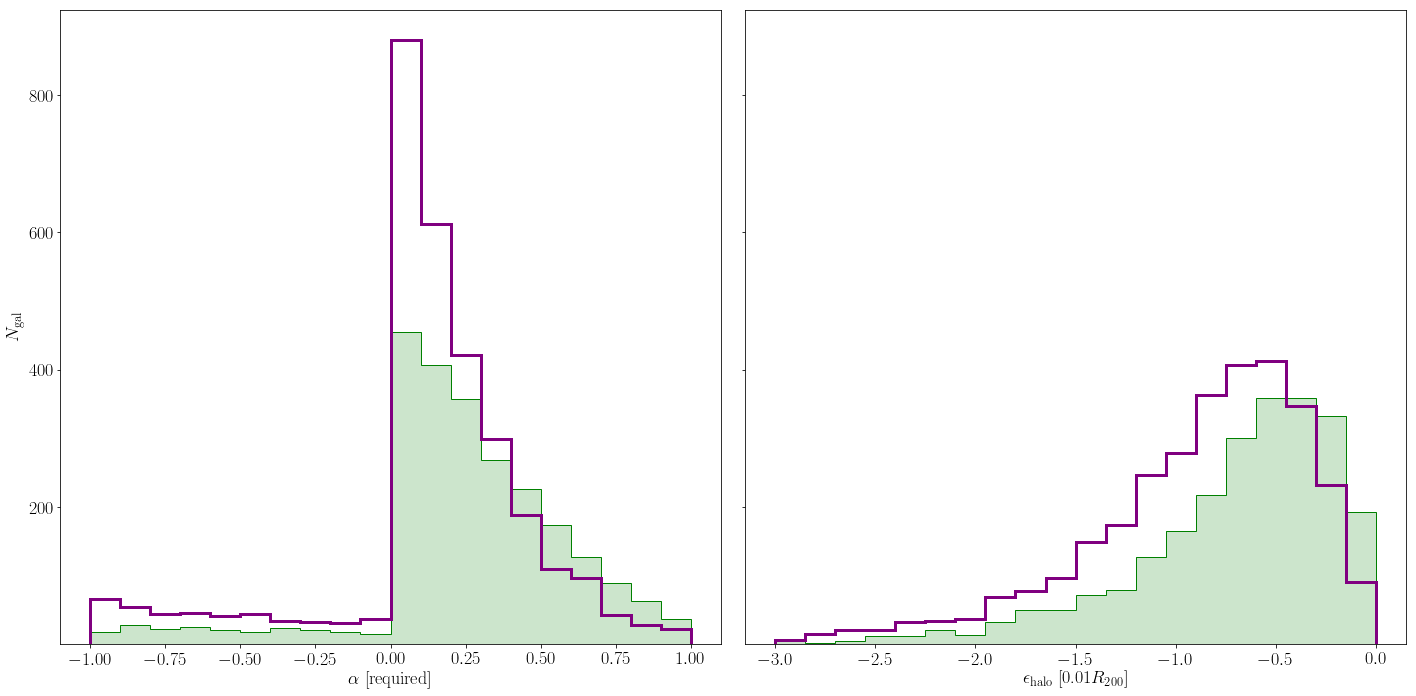

In [14]:
fig, axarr = plt.subplots(1,2,figsize=(20,10),sharey=True)

plt.sca(axarr[0])

bins = np.linspace(-1,1,21)
plt.hist(alphas[in_sdss],bins,
         color='purple',histtype='step',lw=3,zorder=1,
         label='SDSS')
plt.hist(alphas_hi[in_sdss_hi],bins,
         color='g',histtype='stepfilled',lw=3,zorder=0,alpha=0.2,
         label=r'SDSS + H\textsc{i}')
plt.hist(alphas_hi[in_sdss_hi],bins,
         color='g',histtype='step',lw=1,zorder=0)

plt.sca(axarr[1])

bins = np.linspace(-3,0,21)
plt.hist(log_epsilon[in_sdss],bins,
         color='purple',histtype='step',lw=3,zorder=1)
plt.hist(log_epsilon_hi[in_sdss_hi],bins,
         color='g',histtype='stepfilled',lw=3,zorder=0,alpha=0.2)
plt.hist(log_epsilon_hi[in_sdss_hi],bins,
         color='g',histtype='step',lw=1,zorder=0)

_ = axarr[1].legend(fancybox=False,edgecolor='k')
_ = axarr[0].set_xlabel(r'$\alpha$ [required]')
_ = axarr[1].set_xlabel(r'$\epsilon_\mathrm{halo}$ [0.01$R_{200}$]')
_ = axarr[0].set_ylabel('$N_\mathrm{gal}$')

fig.tight_layout()

alpha_ok = alphas[in_sdss] > -1
alpha_ok_hi = alphas_hi[in_sdss_hi] > -1

a, a_ = alpha_ok.sum(), len(alpha_ok)
b, b_ = alpha_ok_hi.sum(), len(alpha_ok_hi)

print('{}/{} ({}%) have reasonable epsilons'.format(a,a_,100*a/a_))

print('{}/{} ({}%) have reasonable epsilons (+HI)'.format(b,b_,100*b/b_))

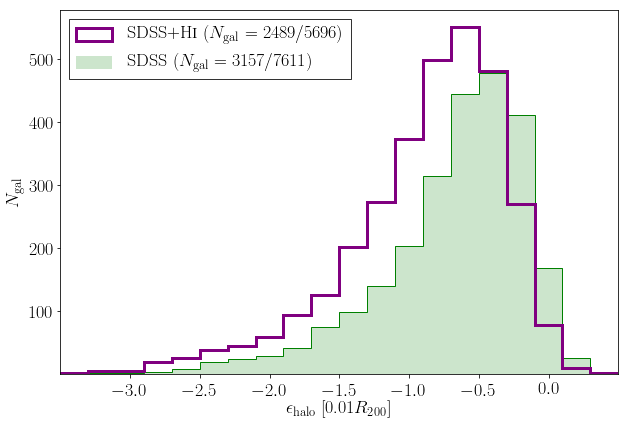

In [15]:
fig = plt.figure(figsize=(10,6.7))
ax = plt.subplot(111)

bins = np.linspace(-3.5,0.5,21)

label = 'SDSS ($N_\mathrm{{gal}}={}/{}$)'.format(
    (alphas[in_sdss] > -1).sum(),in_sdss.sum())

hilabel = r'SDSS+H\textsc{{i}} ($N_\mathrm{{gal}}={}/{}$)'.format(
    (alphas_hi[in_sdss_hi] > -1).sum(),in_sdss_hi.sum())

plt.hist(log_epsilon[in_sdss],bins,
         color='purple',histtype='step',lw=3,zorder=1,
         label=hilabel)
plt.hist(log_epsilon_hi[in_sdss_hi],bins,
         color='g',histtype='stepfilled',lw=3,zorder=0,alpha=0.2,
         label=label)
plt.hist(log_epsilon_hi[in_sdss_hi],bins,
         color='g',histtype='step',lw=1,zorder=0)

_ = plt.legend(fancybox=False,edgecolor='k',loc='upper left')
_ = plt.xlabel(r'$\epsilon_\mathrm{halo}$ [0.01$R_{200}$]')
_ = plt.ylabel('$N_\mathrm{gal}$')

_ = plt.xlim(-3.5,0.5)
fig.savefig('figures/epsilon_required.pdf')

#### Correlate alpha w.r.t:

- Stellar mass
- disc scale length

In [16]:
M_bulge = halo_data['M_bulge']
r_bulge = halo_data['R_bulge']

r_disc = halo_data['R_disc']
r_disc_hi = halo_w_gas['R_disc']
M_disc = halo_data['M_disc']
M_disc_hi = halo_w_gas['M_disc']

r200 = halo_data['R200']

r_half = halo_data['r_half']
r_half_hi = halo_w_gas['r_half']

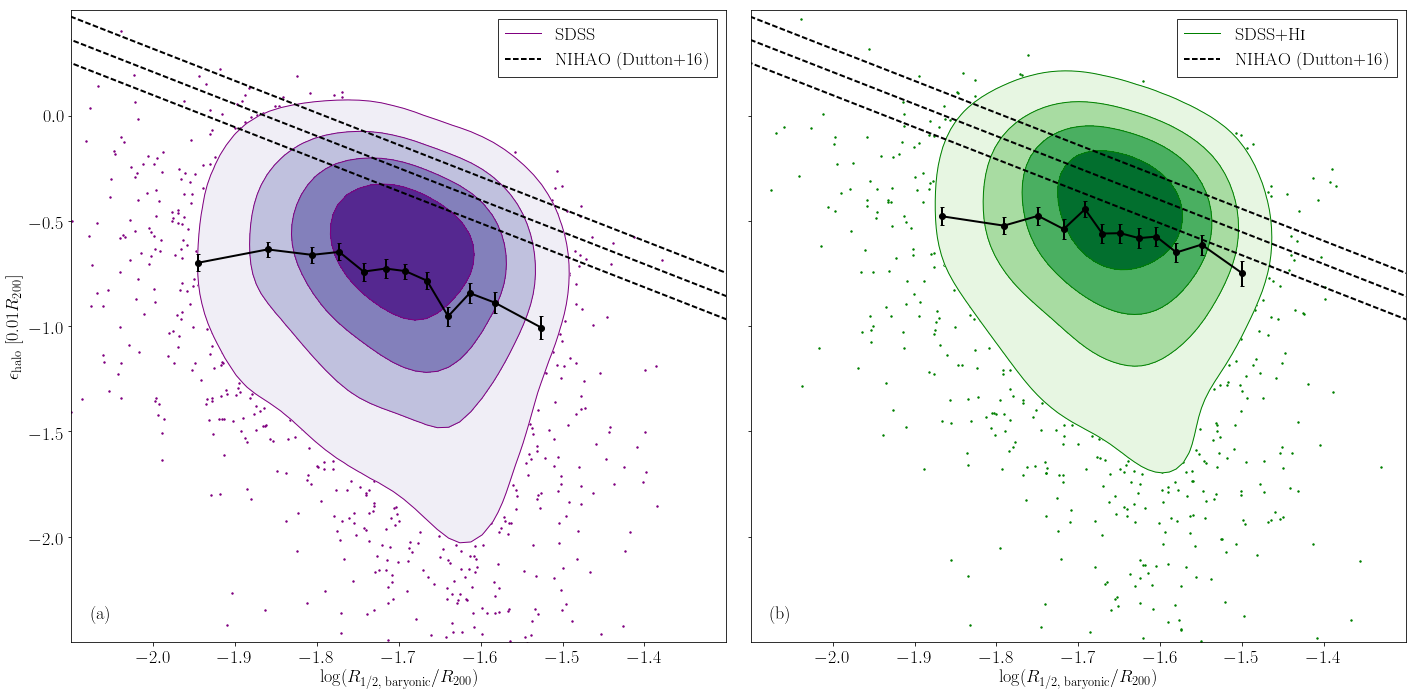

In [17]:
from xy_plots import x_vs_y
from contours import kde_contour

contour = True

def nihao_line(x,plot=True):
    median_line = -0.28 - 1.52 * (1.68 + x)
    lower_line = -0.39 - 1.52 * (1.68 + x)
    upper_line = -0.17 - 1.52 * (1.68 + x)
    
    if plot is True:
        _ = plt.plot(x,lower_line,color='k',lw=2,linestyle='dashed')
        _ = plt.plot(x,median_line,color='k',lw=2,linestyle='dashed',
                     label='NIHAO (Dutton+16)')
        _ = plt.plot(x,upper_line,color='k',lw=2,linestyle='dashed')
        
    return median_line, lower_line, upper_line

x_guide = np.linspace(-2.25,-1.25,100)

fig, axarr = plt.subplots(1,2,figsize=(20,10),sharex=True,sharey=True)

###################################
plt.sca(axarr[0])
_ = plt.text(0.03,0.03,'(a)',ha='left',va='bottom',
             transform=axarr[0].transAxes)

x = np.log10(r_half / r200)[in_sdss]
y = log_epsilon[in_sdss]
xy_ok = np.all([np.isfinite(x),np.isfinite(y),x>-100,y>-100],axis=0)
xy = x_vs_y(x[xy_ok],y[xy_ok]).continuous_vs_continuous_binned_median(
                                                  equal_N=True,bins=12)
xy.error_plot(axarr[0],style='errorbar',
              color='k',lw=2,capsize=2,marker='o')

_ = plt.scatter(x,y,color='purple',s=2,rasterized=True,zorder=-1,
                label='_nolegend_')
if contour is True:
    _ = kde_contour(x,y,x_range=(-10,10),y_range=(-10,10),fill=True,
                    line_properties={'color':'purple'},
                    fill_properties={'colormap':'Purples'})

_ = plt.plot([],[],color='purple',lw=1,label=r'SDSS')
_ = nihao_line(x_guide)
###################################
plt.sca(axarr[1])
_ = plt.text(0.03,0.03,r'(b)',ha='left',va='bottom',
             transform=axarr[1].transAxes)

x = np.log10(r_half_hi/r200)[in_sdss_hi]
y = log_epsilon_hi[in_sdss_hi]
xy_ok = np.all([np.isfinite(x),np.isfinite(y),x>-100,y>-100],axis=0)
xy = x_vs_y(x[xy_ok],y[xy_ok]).continuous_vs_continuous_binned_median(
                                                  equal_N=True,bins=12)
xy.error_plot(axarr[1],style='errorbar',
              color='k',lw=2,capsize=2,marker='o')#,label='_nolegend_')

_ = plt.scatter(x,y,color='g',s=2,rasterized=True,zorder=-1,
                label='_nolegend_')
if contour is True:
    _ = kde_contour(x,y,x_range=(-10,10),y_range=(-10,10),fill=True,
                    line_properties={'color':'g'},
                    fill_properties={'colormap':'Greens'})

_ = plt.plot([],[],color='g',lw=1,label=r'SDSS+H\textsc{i}')
_ = nihao_line(x_guide)
###################################
_ = axarr[0].set_xlabel('$\log(R_\mathrm{1/2, \, baryonic} / R_{200})$')
_ = axarr[1].set_xlabel('$\log(R_\mathrm{1/2, \, baryonic} / R_{200})$')
_ = axarr[0].set_ylabel(r'$\epsilon_\mathrm{halo}$ [0.01$R_{200}$]')

_ = axarr[0].set_xlim(-2.1,-1.3)
_ = axarr[0].set_ylim(-2.5,0.5)

for ax in axarr:
    _ = ax.legend(edgecolor='k',fancybox=False)

_ = fig.tight_layout()
fig.savefig('figures/r_vs_epsilon.pdf')

In [18]:
def epsilon_expected_nihao(r_half,r200,N_sigma):
    log_hmf = -0.28 * -1.52*(np.log10(r_half/r200)+1.68) - N_sigma*0.17
    return 10**(log_hmf)

def alpha_to_m(alpha,m_b,m_d,m_hernquist,m_burkert):
    low_alpha = alpha < 0
    mid_alpha = (alpha >= 0) & (alpha <= 1)
    high_alpha = alpha > 1
    m = np.zeros(len(alpha))
    m[low_alpha] = (m_b + m_d + (1+alpha)*m_burkert)[low_alpha]
    m[mid_alpha] = (m_b + m_d + (1-alpha)*m_burkert + alpha*m_hernquist)[mid_alpha]
    m[high_alpha] = (m_b + m_d + alpha*m_hernquist)[high_alpha]
    return m
    

epsilon_nihao = epsilon_expected_nihao(r_half,r200,0)
epsilon_nihao_hi = epsilon_expected_nihao(r_half_hi,r200,0)

alpha_nihao = epsilon_to_alpha(halo_data,epsilon_nihao)
alpha_nihao_hi = epsilon_to_alpha(halo_w_gas,epsilon_nihao_hi)

m_predicted_nihao = alpha_to_m(alpha_nihao,m_bulge,m_disc,
                               m_hernquist,m_burkert)

m_predicted_nihao_hi = alpha_to_m(alpha_nihao_hi,m_bulge_hi,m_disc_hi,
                                  m_hernquist_hi,m_burkert_hi)

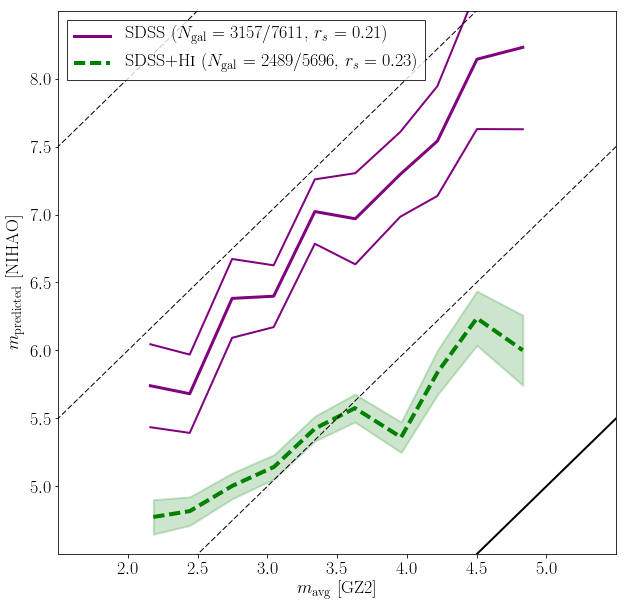

In [19]:
from scipy.stats import spearmanr
N = 0

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

sdss_ok = np.all([in_sdss,alphas>-1],axis=0)
sdss_ok_hi = np.all([in_sdss_hi,alphas_hi>-1],axis=0)

x = morph_data['m_avg'][sdss_ok]
y = m_predicted_nihao[sdss_ok]
xy = x_vs_y(x,y).continuous_vs_continuous_binned_median()
r_s, _ = spearmanr(x,y)
r_s = np.round(r_s,2)
L = 'SDSS ($N_\mathrm{{gal}}={}/{}$, $r_s={}$)'.format(sdss_ok.sum(),
                                                       in_sdss.sum(),r_s)


xy.line_plot(ax,color='purple',lw=3,label=L)
xy.error_plot(ax,style='lined',lw=2,color='purple')

#######################

x = morph_data['m_avg'][sdss_ok_hi]
y = m_predicted_nihao_hi[sdss_ok_hi]
xy = x_vs_y(x,y).continuous_vs_continuous_binned_median()
r_s, _ = spearmanr(x,y)
r_s = np.round(r_s,2)
L = r'SDSS+H\textsc{{i}} ($N_\mathrm{{gal}}={}/{}$, $r_s={}$)'.format(
                                 sdss_ok_hi.sum(),in_sdss_hi.sum(),r_s)
xy.line_plot(ax,color='g',lw=4,linestyle='dashed',label=L)
xy.error_plot(ax,style='filled',lw=2,color='g',alpha=0.2)

########################

_ = ax.set_xlabel('$m_\mathrm{avg}$ [GZ2]')
_ = ax.set_ylabel('$m_\mathrm{predicted}$ [NIHAO]')

_ = ax.plot([-10,10],[-10,10],color='k',lw=2)
for offset in (-2,2,4,6,8):
    _ = ax.plot([-10,10],[-10+offset,10+offset],
                color='k',lw=1,linestyle='dashed')

    _ = ax.set_xlim(1.5,5.5)
    _ = ax.set_ylim(4.5-N,8.5-N)
_ = ax.legend(loc='upper left',edgecolor='k',fancybox=False)

fig.savefig('figures/m_vs_m_nihao.pdf')

#### Final task: compare psis as per SPB

In [27]:
psi_data = Table.read('../sparcfire2/fits/galaxy_level_all.fits')
has_psi = psi_data['N_arcs'] >= 1

psi = psi_data['P_wtd_avg']
psi_predicted = halo_data['psi_burkert']

/home/ppxrh/anaconda3/lib/python3.4/site-packages/numpy/core/fromnumeric.py:639: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


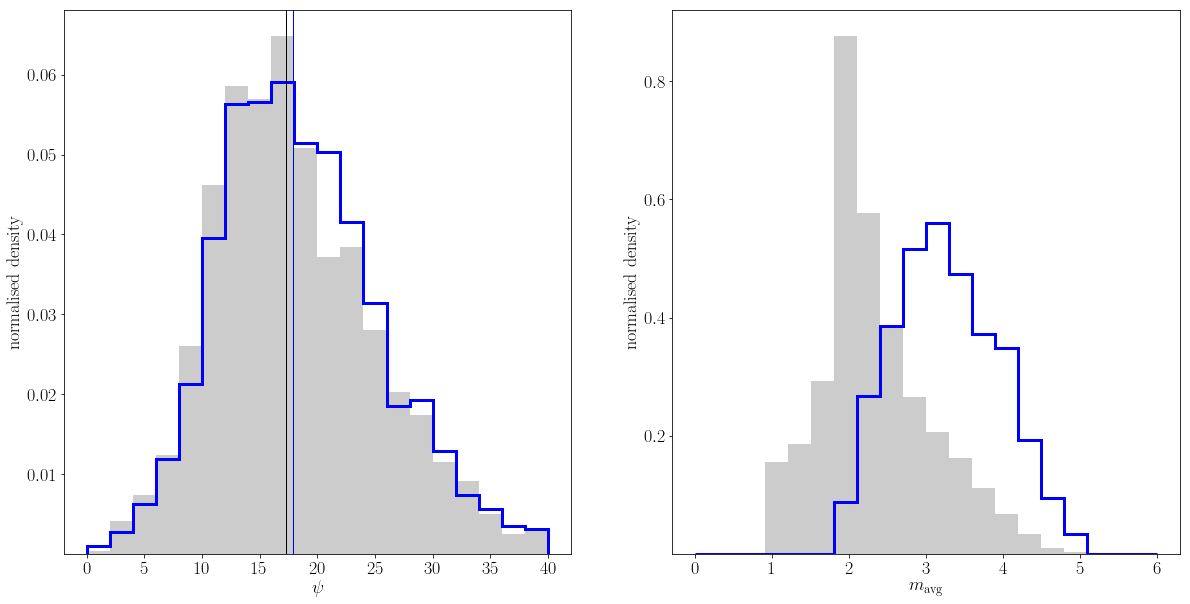

In [22]:
fig, axarr = plt.subplots(1,2,figsize=(20,10))

m_avg = morph_data['m_avg']

# masks
modal = sdss_ok.copy()
non_modal = np.all([in_sdss,sdss_ok == False],axis=0)

modal_psi = np.all([modal,has_psi],axis=0)
non_modal_psi = np.all([non_modal,has_psi],axis=0)

plt.sca(axarr[0])
#
bins = np.linspace(0,40,21)

_ = plt.hist(psi[non_modal_psi],bins,normed=True,
             color='k',histtype='stepfilled',alpha=0.2)
_ = plt.hist(psi[modal_psi],bins,normed=True,
             color='b',histtype='step',lw=3)
_ = plt.axvline(np.median(psi[non_modal_psi]),color='k',lw=1)
_ = plt.axvline(np.median(psi[modal_psi]),color='b',lw=1)

_ = plt.xlabel('$\psi$')
_ = plt.ylabel('normalised density')

#####################################################
plt.sca(axarr[1])
#
bins = np.linspace(0,6,21)

_ = plt.hist(m_avg[non_modal],bins,normed=True,
             color='k',histtype='stepfilled',alpha=0.2)
_ = plt.hist(m_avg[modal],bins,normed=True,
             color='b',histtype='step',lw=3)

_ = plt.xlabel('$m_\mathrm{avg}$')
_ = plt.ylabel('normalised density')

In [38]:
_ = plt.scatter(psi[non_modal_psi],psi)

796 3157
3176 4454


#### Now: need to convert the halo mass fractions

Require the following outputs:

- Halo mass (Hernquist)
- $R_{200}$
- $\rho_0$ (Burkert)

In [ ]:
###############
def mass_enclosed_hernquist(r,M200,a_h,r200):
    return M200 * (r**2 / (r+a_h)**2)

def mass_enclosed_burkert(r,M200,a_h,rho0,r200):
    
    a = 2 * math.pi * rho0 * a_h**3
    b = (np.log((r+a_h)/a_h)
       + 0.5 * np.log((r**2 + a_h**2)/a_h**2)
       - np.arctan(r/a_h))
    return a * b

def alpha_mass_enclosed(alphas,M_burkert,M_hernquist):
    low_alpha = alphas < 0
    mid_alpha = (0 <= alphas) & (alphas <= 1)
    high_alpha = alphas > 1
    mass_enclosed = np.zeros(len(alphas))
    mass_enclosed[low_alpha] = (1+alphas[low_alpha])*M_burkert[low_alpha]
    mass_enclosed[mid_alpha] = ((1-alphas[mid_alpha])*M_burkert[mid_alpha] 
                              + alphas[mid_alpha]*M_hernquist[mid_alpha])
    mass_enclosed[high_alpha] = (1+alphas[high_alpha])*M_hernquist[high_alpha]
    return mass_enclosed

def linear(x,m,c):
    return m*x + c

def get_hmf(table,alphas):
    M200_hernquist = table['modified_M_halo']
    M200_burkert = table['M_halo']
    R200 = table['R200']
    a_h = table['R_halo']
    rho0 = table['rho0_burkert']
    r = 0.01 * R200
    
    M_hernquist = mass_enclosed_hernquist(r,M200_hernquist,a_h,R200)
    M_burkert = mass_enclosed_burkert(r,M200_burkert,a_h,rho0,R200)

    mass_enclosed = alpha_mass_enclosed(alphas,M_burkert,M_hernquist)
    return mass_enclosed / M_hernquist


In [ ]:
from xy_plots import x_vs_y

def m_avg_vs_m(ax,morph_data,mask,hi_mask,m_predicted,m_predicted_hi):

    m = morph_data['m']
    m_avg = morph_data['m_avg']

    x = m_avg[mask]
    y = m_predicted[mask]
    rs, _ = np.round(spearmanr(x,y),2)
    label='SDSS ($N_\mathrm{{gal}}={}$, $r_s$={})'.format(len(x),rs)

    xy = x_vs_y(x,y).continuous_vs_continuous_binned_median(equal_N=True)
    _ = xy.line_plot(ax,color='purple',lw=4,label=label)
    _ = xy.error_plot(ax,style='lined',color='purple',linestyle='dashed')

    #######################
    x = m_avg[hi_mask]
    y = m_predicted_hi[hi_mask]
    rs, _ = np.round(spearmanr(x,y),2)
    label=r'SDSS+H\textsc{{i}} ($N_\mathrm{{gal}}={}$, $r_s$={})'.format(
          len(x),rs)

    xy = x_vs_y(x,y).continuous_vs_continuous_binned_median(equal_N=True)
    _ = xy.line_plot(ax,color='g',lw=2,label=label)
    _ = xy.error_plot(ax,color='g',alpha=0.2)

    ###############
    _ = ax.plot([-10,10],[-10,10],color='k',lw=2)
    for offset in (-2,2,4,6,8):
        _ = ax.plot([-10,10],[-10+offset,10+offset],
                    color='k',lw=1,linestyle='dashed')

    _ = ax.set_xlim(1.5,5.5)
    _ = ax.set_ylim(2.5,6.5)
    _ = ax.legend(edgecolor='k',fancybox=False)
    
    return None

def m_vs_m(ax,morph_data,mask,hi_mask,m_predicted,m_predicted_hi):

    m = morph_data['m']
    m_avg = morph_data['m_avg']

    x = m[mask]
    y = m_predicted[mask]
    rs, _ = np.round(spearmanr(x,y),2)
    label='SDSS ($N_\mathrm{{gal}}={}$, $r_s$={})'.format(len(x),rs)

    xy = x_vs_y(x,y).discrete_vs_continuous_binned_median()
    _ = xy.line_plot(ax,color='purple',lw=4,label=label)
    _ = xy.error_plot(ax,style='lined',color='purple',linestyle='dashed')

    #######################
    x = m[hi_mask]
    y = m_predicted_hi[hi_mask]
    rs, _ = np.round(spearmanr(x,y),2)
    label=r'SDSS+H\textsc{{i}} ($N_\mathrm{{gal}}={}$, $r_s$={})'.format(
          len(x),rs)

    xy = x_vs_y(x,y).discrete_vs_continuous_binned_median()
    _ = xy.line_plot(ax,color='g',lw=2,label=label)
    _ = xy.error_plot(ax,color='g',alpha=0.2)

    ###############
    _ = ax.plot([-10,10],[-10,10],color='k',lw=2)
    for offset in (-2,2,4,6,8):
        _ = ax.plot([-10,10],[-10+offset,10+offset],
                    color='k',lw=1,linestyle='dashed')

    _ = ax.set_xlim(1.5,5.5)
    _ = ax.set_ylim(2.5,6.5)
    _ = ax.legend(edgecolor='k',fancybox=False)
    
    return None

In [ ]:
### Make the plots above for bins of alpha:

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)
m = morph_data['m']

mask = np.all([alphas >= -1,#alphas <= 10,
               in_sdss,m>=2,m_nihao>=0],axis=0)
hi_mask = np.all([alphas_hi >= -1,#alphas_hi <= 10,
                  in_sdss_hi,m>=2,m_nihao_hi>=0],axis=0)

_ = m_avg_vs_m(ax,morph_data,mask,hi_mask,m_nihao,m_nihao_hi)

_ = ax.set_xlabel('$m_\mathrm{avg}$ [GZ2]')
_ = ax.set_ylabel('$m_\mathrm{predicted}$')

#fig.savefig('figures/m_vs_m_nihao.pdf')

In [ ]:
gz2_data = Table.read('../fits/full_sample_debiased_w_low_z_mod.fits')

In [ ]:
fd_nihao = M_d / (M_b + M_d + hmf*M_h_hernquist)
M_total = np.log10(M_b + M_d + hmf*M_h_hernquist)
M_disc = np.log10(M_b)
u_r = gz2_data['PETROMAG_MU'] - gz2_data['PETROMAG_MR']

In [ ]:
from bin_statistics import assign_bins
from scipy.stats import spearmanr

#mask = np.all([alphas >= 0,alphas <= 1,
               #in_sdss,m>=2,m_nihao>=0],axis=0)

x = morph_data['m_avg'][mask]
y = m_nihao[mask]
z = u_r[mask]

def moving_rs(x,y,z,N_bins=20):

    order = np.argsort(z)
    x, y, z = x[order], y[order], z[order]
    zbins = assign_bins(z,equal_N=True,N_bins=N_bins)
    
    zs = []
    rs = []
    p = []
    
    for zbin in np.unique(zbins):
        in_bin = zbins == zbin
        xbin = x[in_bin]
        ybin = y[in_bin]
        zbin = z[in_bin]
        zs.append(np.mean(zbin))
        rs.append(spearmanr(xbin,ybin)[0])
        p.append(spearmanr(xbin,ybin)[1])
    
    return zs, rs, p

z_, rs, p = moving_rs(x,y,z,20)

plt.plot(z_,rs)

In [ ]:
modal = np.all([alphas >= -1,
                in_sdss,m>=2,m_nihao>=0],axis=0)

non_modal = np.all([alphas <= -1,
                    in_sdss,m>=2,m_nihao>=0],axis=0)

bins = np.linspace(1.5,5.5,20)

plt.hist(morph_data['m_avg'][modal],bins,color='b',alpha=0.2)
plt.hist(morph_data['m_avg'][non_modal],bins,color='k',histtype='step',lw=3)

In [ ]:
from display_image import display_image

np.random.seed(0)

fig, axarr = plt.subplots(4,4,figsize=(20,20))

low_z = gz2_data['REDSHIFT_1'] <= 0.085

for m, ax in enumerate(axarr):
    m_ok = morph_data['m'] == m+2
    non_modal_m = np.all([non_modal,m_ok,low_z],axis=0)
    modal_m = np.all([modal,m_ok,low_z],axis=0)
    non_modal_urls = np.random.choice(gz2_data['jpeg_url'][non_modal_m],2)
    modal_urls = np.random.choice(gz2_data['jpeg_url'][modal_m],2)
    
    plt.sca(ax[0])
    display_image(non_modal_urls[0])
    plt.sca(ax[1])
    display_image(non_modal_urls[1])
    plt.sca(ax[2])
    display_image(modal_urls[0])
    plt.sca(ax[3])
    display_image(modal_urls[1])
    

#### How does the NIHAO modification affect the correlation?

- Try this for various offsets: 

#### Now for the f_d vs. m relation for bins of alpha:

In [ ]:
from scipy.optimize import curve_fit

def linear(x,m,c):
    return m*x + c

def quadratic(x,a,b,c):
    return a*x**2 + b*x + c

def cubic(x,a,b,c,d):
    return a*x**3 + b*x**2 + c*x + d

def n4(x,a,b,c,d,e):
    return a*x**4 + b*x**3 + c*x**2 + d*x + e

x_guide = np.linspace(0,1,1000)

fig, axarr = plt.subplots(1,2,figsize=(10,5))

p_k, _ = curve_fit(quadratic,test_alphas,ks,p0=(1,1,1))
_ = axarr[0].plot(test_alphas,ks,color='k',lw=1)
_ = axarr[0].plot(x_guide,quadratic(x_guide,*p_k),
                  color='r',lw=2,linestyle='dashed')

p_c, _ = curve_fit(n4,test_alphas,cs)
_ = axarr[1].plot(test_alphas,cs,color='k',lw=1)
_ = axarr[1].plot(x_guide,n4(x_guide,*p_c),
                  color='b',lw=2,linestyle='dashed')

_ = axarr[0].set_xlabel(r'$\alpha$')
_ = axarr[0].set_ylabel('$k$')
_ = axarr[1].set_xlabel(r'$\alpha$')
_ = axarr[1].set_ylabel('$c$')

_ = fig.tight_layout()

In [ ]:
def correct_fd(halo_table,morph_table,alphas,k_func,c_func,p_k,p_c):
    
    def fd_function(x,k,c):
        return k / x + c
    
    def inverse_fd_function(y,k,c):
        return k /(y-c)
    
    k = k_func(alphas,*p_k)
    c = c_func(alphas,*p_c)
    
    disc_mass_22 = halo_table['M_disc_total_2.2']
    bulge_mass_22 = halo_table['M_bulge_2.2']
    halo_mass_22_hernquist = halo_table['M_halo_2.2_hernquist']
    halo_mass_22_burkert = halo_table['M_halo_2.2_burkert']
    m_observed = morph_table['m_avg']
    halo_mass_22 = ((alpha * halo_mass_22_hernquist) 
                  + ((1-alpha) * halo_mass_22_burkert))
    
    fd_observed = (disc_mass_22 
                  / (disc_mass_22 + bulge_mass_22 + halo_mass_22))
    
    fd_required = inverse_fd_function(m_observed,k,c)
    
    return fd_observed, fd_required


def correct_m(halo_table,mass_correction,alphas,k_func,c_func,p_k,p_c):
    
    def fd_function(x,k,c):
        return k / x + c
    
    def inverse_fd_function(y,k,c):
        return k /(y-c)
    
    k = k_func(alphas,*p_k)
    c = c_func(alphas,*p_c)
    
    disc_mass_22 = halo_table['M_disc_total_2.2'] + mass_correction
    bulge_mass_22 = halo_table['M_bulge_2.2'] - mass_correction
    halo_mass_22_hernquist = halo_table['M_halo_2.2_hernquist']
    halo_mass_22_burkert = halo_table['M_halo_2.2_burkert']
    halo_mass_22 = ((alpha * halo_mass_22_hernquist) 
                  + ((1-alpha) * halo_mass_22_burkert))
    
    fd = (disc_mass_22 
        / (disc_mass_22 + bulge_mass_22 + halo_mass_22))
    
    m_predicted = fd_function(fd,k,c)
    return m_predicted
    

In [ ]:
mask = np.all([sample_ok,mask0],axis=0)

fd_observed, fd_required = correct_fd(halo_data[mask],morph_data[mask],
                                      alpha_nihao[mask],
                                      quadratic,n4,p_k,p_c)

mb_correction = ((fd_required-fd_observed) 
                * halo_data[mask]['M_disc_total_2.2'])

mb_22_observed = halo_data['M_bulge_2.2'][mask]
mb_22_required = mb_22_observed - mb_correction

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

ok_mb = np.all([mb_22_required > 10**7,mb_22_required <= 10**13,
                mb_22_observed > 10**7,mb_22_observed <= 10**13],axis=0)

print('{}/{} have reasonable bulges'.format(ok_mb.sum(),mask.sum()))

x = np.log10(mb_22_observed[ok_mb])
y = np.log10(mb_22_required[ok_mb])
xy = x_vs_y(x,y).continuous_vs_continuous_binned_median(equal_N=True,bins=20)
xy.error_plot(ax,style='errorbar',color='k',lw=2)

_ = ax.scatter(x,y,s=1,color='r')
_ = ax.set_xlabel('$\log(\mathrm{M_B/M_\odot})$ [Mendel+14]')
_ = ax.set_ylabel('$\log(\mathrm{M_B/M_\odot})$ [required]')

_ = ax.set_xlim(7,12)
_ = ax.set_ylim(7,12)
_ = ax.plot([7,12],[7,12],color='k',lw=1,linestyle='dotted')

In [ ]:
bins = np.linspace(-2,3,21)
required_fraction = mb_22_required/mb_22_observed
plt.hist(required_fraction,bins,color='r',histtype='stepfilled',
         alpha=0.3)

_ = plt.xlabel('$\mathrm{M_B}$ (required) / $\mathrm{M_B}$ (observed)')
_ = plt.ylabel('$N_\mathrm{gal}$')

In [ ]:
fig = plt.figure()
ax = plt.subplot(111)
plt.sca(ax)

x = np.log10(mb_22_observed)
y = required_fraction
xy_ok = np.all([y >= -100, y <= 100, np.isfinite(x)],axis=0)

xy = x_vs_y(x[xy_ok],y[xy_ok]).continuous_vs_continuous_binned_median(
    equal_N=True,bins=12)
xy.scatter(ax,color='r',s=1,label=label)
rs = xy.spearmanr(None,plot=False)[0]
label = r'SDSS $\alpha>1$ ($N_\mathrm{{gal}}={}$, {})'.format(len(x),rs)
xy.error_plot(ax,color='k',lw=2,style='errorbar',marker='o',capsize=2)

_ = ax.legend(fancybox=False,edgecolor='k')

_ = plt.axhline(0,linestyle='dotted',color='k')
_ = plt.axhline(1,linestyle='dotted',color='k')

p_corr, pcov = curve_fit(linear,x[xy_ok],y[xy_ok])
x_guide = np.linspace(6,12,100)
y_guide = linear(x_guide,*p_corr)

_ = ax.set_xlim(7.5,11.5)
_ = ax.set_ylim(-1,2)
_ = ax.set_xlabel('$\log(\mathrm{M_B/M_\odot})$')
_ = ax.set_ylabel('$\mathrm{M_B}$ (required) / $\mathrm{M_B}$ (observed)')

bulge_correction_x = xy.x_table['mean']
bulge_correction_y = xy.y_table['mean']

#### New task: fit the S4G...

In [ ]:
s4g = Table.read('fits/s4g_halo_table_matched.fits')
s4g_morph = Table.read('s4g_fits/buta_matched.fits')
s4g_structure = Table.read('s4g_fits/bulge_disc_matched.fits')

in_s4g = s4g['unbarred_sample']

In [ ]:
s4g_R_ratio = np.log10(1.68*s4g['R_disc_total']/s4g['R200'])
s4g_alpha_nihao = 10**(nihao_line(s4g_R_ratio)[0])

In [ ]:
m_hernquist_s4g = s4g['m_hernquist_2R_d']
m_burkert_s4g = s4g['m_burkert_2R_d']

s4g_m_mod = m_predicted(m_burkert_s4g,m_hernquist_s4g,s4g_alpha_nihao)

In [ ]:
fig = plt.figure(figsize=(10,6.7))
ax = plt.subplot(111)

arm_class = s4g_morph['AC'][in_s4g]
ac_number = np.zeros(len(arm_class))
ac_number[arm_class == b'G'] = 1
ac_number[arm_class == b'M'] = 2
ac_number[arm_class == b'F'] = 3

x = ac_number.copy()
y_h = s4g['m_hernquist_2R_d'][in_s4g]
y_b = s4g['m_burkert_2R_d'][in_s4g]
y_nihao = s4g_m_mod[in_s4g]

xy_h = x_vs_y(x,y_h).discrete_vs_continuous_binned_median()
xy_b = x_vs_y(x,y_b).discrete_vs_continuous_binned_median()
xy_nihao = x_vs_y(x,y_nihao).discrete_vs_continuous_binned_median()

_ = xy_h.error_plot(ax,lw=4,style='errorbar',
                    color='orangered',label=r'S$^4$G (Hernquist)',
                    linestyle='dashed',capsize=4,capthick=2,marker='o')
_ = xy_b.error_plot(ax,lw=2,style='errorbar',
                    color='darkblue',label=r'S$^4$G (Burkert)',
                    capsize=4,capthick=2,marker='s')

_ = xy_nihao.error_plot(ax,lw=1,style='errorbar',
                        color='k',label=r'S$^4$G (NIHAO)',
                        capsize=4,capthick=1,marker='^')

_ = ax.set_xlabel('arm class')
_ = ax.set_ylabel('$m_\mathrm{predicted}$')
_ = ax.set_xticks([1,2,3])
_ = ax.set_xticklabels(['G','M','F'])
_ = ax.legend(fontsize=15,fancybox=False,edgecolor='k')

#fig.savefig('figures/m_vs_m_s4g.pdf')
print(xy_h.y_table)

#### Final task: test a set of variables w.r.t |alpha-alpha (predicted)|

In [ ]:
#gz2_data = Table.read('../fits/full_sample_debiased_w_low_z_mod.fits')

In [ ]:
'''
x = np.array(bulge_correction_x)#[5:]
y = np.array(bulge_correction_y)#[5:]
plt.scatter(x,y,color='k')
    
func = cubic

p, _ = curve_fit(func,x,y)
x_g = np.linspace(8.5,10.5,100)
y_g = func(x_g,*p)
plt.plot(x_g,y_g,color='r')
'''

In [ ]:
mask = np.all([sample_ok,alphas > -1],axis=0)

delta_hmf = np.abs(np.log10(hmf) - np.log10(hmf_expected))[mask]
density = gz2_data['IVAN_DENSITY']
p_loose = gz2_data['t10_arms_winding_a30_loose_debiased_rh']
p2 = gz2_data['t11_arms_number_a32_2_debiased_rh']
f2 = morph_data['m'] == 2
m_bulge = np.log10(halo_data['M_bulge'])
m_bulge[np.isfinite(m_bulge) == False] = 7

columns = ['t10_arms_winding_a30_loose_debiased_rh',
           't10_arms_winding_a29_medium_debiased_rh',
           't10_arms_winding_a28_tight_debiased_rh']

In [ ]:
from contours3 import xyz_contour

fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111)
plt.sca(ax)

x = morph_data['m_avg'][mask]
y = m_predicted_nihao[mask]
z = p_loose[mask]

_ = xyz_contour(x,y,z,y_range=(0,10),fill_properties={'colormap':'viridis'})
_ = plt.colorbar()
_ = plt.xlabel('$m_\mathrm{avg}$ [GZ2]')
_ = plt.ylabel('$m_\mathrm{predicted}$')

In [ ]:
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111)
plt.sca(ax)

x = morph_data['m_avg'][mask]
y = m_predicted_nihao[mask]
z = density[mask]

_ = xyz_contour(x,y,z,y_range=(0,10),fill_properties={'colormap':'viridis'})
_ = plt.colorbar()